In [1]:
import healpy as hp
from scipy import interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import coop_post_processing as cpp
from astropy.io import fits
from astropy import units as u
from scipy import signal
from astropy.cosmology import Planck15 as cosmo, z_at_value
import coop_setup_funcs as csf


In [25]:
nside = 512

In [52]:
def smooth_map(map, mask, scale=None, mode='gauss', bw=None):
    if mode=='gauss':
        smthmap = hp.sphtfunc.smoothing(odmap, fwhm = scale)*mask
    else:
        smthmap = hp.sphtfunc.smoothing(odmap, beam_window=bw)*mask
    return smthmap

def get_rms_nu(od_map, mask, cl_pix):
    mean_od = sum(od_map*mask)/sum(mask)
    rms = np.sqrt(sum((od_map-mean_od)**2*mask)/sum(mask))
    nu = ((od_map-mean_od)*mask) / rms
    return(rms, nu[cl_pix])

    

In [3]:
odmap = hp.read_map("/mnt/raid-cita/mlokken/buzzard/number_density_maps/des_reg/odmap_distMpc_1432_1632_0Mpc_0arcmin.fits")
rm_mask = hp.read_map("/mnt/raid-cita/mlokken/masks/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_hpx.fit")

/home/mlokken/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [32]:
odmap = hp.ud_grade(odmap, nside)
rm_mask = hp.ud_grade(rm_mask, nside)

In [18]:
cls = fits.open("/mnt/raid-cita/mlokken/buzzard/catalogs/buzzard_1.9.9_3y3a_rsshift_run_redmapper_v0.5.1_lgt20_vl50_catalog.fit")
cldat = cls[1].data
ra, dec, redshift = cldat['ra'], cldat['dec'], cldat['z']
zmin,zmax = z_at_value(cosmo.comoving_distance, 1432*u.Mpc), z_at_value(cosmo.comoving_distance, 1632*u.Mpc)
inz = (redshift<zmax) & (redshift>zmin)
ra = ra[inz]
dec = dec[inz]

In [21]:
z = z_at_value(cosmo.comoving_distance, 1532*u.Mpc)

In [107]:
smth_scale = (cosmo.arcsec_per_kpc_comoving(z)*(8/cosmo.h*u.Mpc).to(u.kpc)).to(u.radian)

In [108]:
def top_hat(b, radius):
    return np.where(abs(b)<=radius, 1, 0)
b = np.linspace(0,np.pi,10000)
bw = top_hat(b, smth_scale.value) #top_hat function of radius 45°
beam = hp.sphtfunc.beam2bl(bw, b, nside*3)


In [112]:
tophat_map = smooth_map(odmap, rm_mask, mode='bw', bw=beam)

Using provided beam window function
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


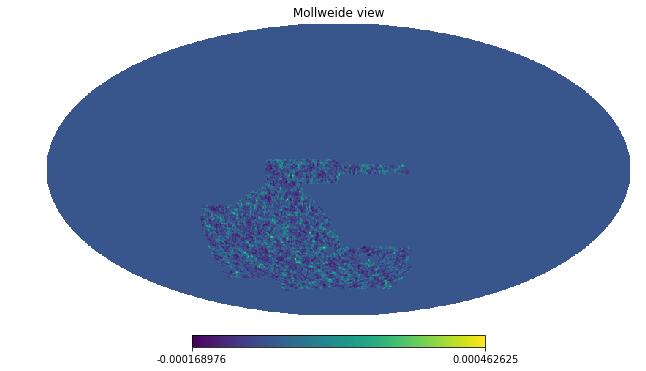

In [113]:
hp.mollview(tophat_map)
cl_pix = hp.ang2pix(nside, ra, dec, lonlat=True)
rms_th, nu_th = get_rms_nu(tophat_map, rm_mask, cl_pix)

In [114]:
smth_scale_g1 = (cosmo.arcsec_per_kpc_comoving(z)*(9.4/cosmo.h*u.Mpc).to(u.kpc)).to(u.radian)
smth_scale_g2 = (cosmo.arcsec_per_kpc_comoving(z)*(14/cosmo.h*u.Mpc).to(u.kpc)).to(u.radian)
smth_scale_g3 = (cosmo.arcsec_per_kpc_comoving(z)*(8/cosmo.h*u.Mpc).to(u.kpc)).to(u.radian)

In [115]:
gauss_map1 = smooth_map(odmap, rm_mask, smth_scale_g1.value)
gauss_map2 = smooth_map(odmap, rm_mask, smth_scale_g2.value)
gauss_map3 = smooth_map(odmap, rm_mask, smth_scale_g3.value)

Sigma is 13.223306 arcmin (0.003847 rad) 
-> fwhm is 31.138506 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 19.694286 arcmin (0.005729 rad) 
-> fwhm is 46.376499 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 11.253878 arcmin (0.003274 rad) 
-> fwhm is 26.500857 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


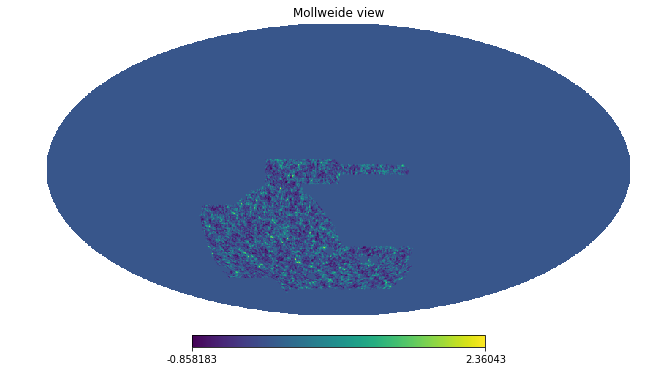

In [116]:
hp.mollview(gauss_map1)
rms_g1, nu_g1 = get_rms_nu(gauss_map1, rm_mask, cl_pix)
rms_g2, nu_g2 = get_rms_nu(gauss_map2, rm_mask, cl_pix)
rms_g3, nu_g3 = get_rms_nu(gauss_map3, rm_mask, cl_pix)

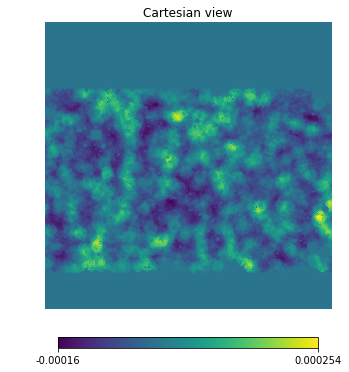

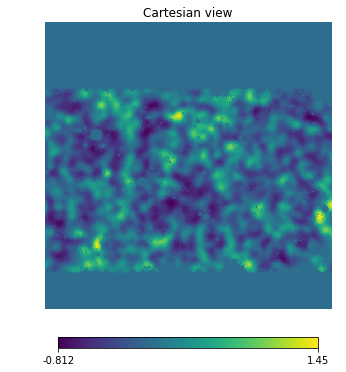

In [118]:
lonra=[0,20]
latra = [-10,10]
hp.cartview(tophat_map, lonra=lonra, latra=latra)
hp.cartview(gauss_map1, lonra=lonra, latra=latra)

In [106]:
np.average(nu_th), np.average(nu_g2)

(2.1850580195022835, 2.0573918807211955, 1.7092659801798318, 2.214535431264062)

In [87]:
nu_th[50:60]

array([ 0.93108314,  1.15001869, -0.24371607, -0.05633218,  1.77691656,
        1.18941873,  1.9963775 ,  1.31151629,  0.71069481,  1.34344548])

In [88]:
nu_g2[50:60]

array([ 1.11044888,  1.24922089, -0.42358534, -0.23974909,  1.68114405,
        0.96478682,  2.11381186,  1.08180685,  0.49886363,  1.33879919])